In [76]:
import pyransac3d as pyrsc
import numpy as np


In [77]:
def load_point_cloud(filename):
    with open(filename, 'r') as f:
        lines = f.read().strip()[2:-2].split(']\n [')

    list_of_points = []
    for line in lines:
        numbers_str = filter(None, line.split(' '))
        list_of_points.append([float(x) for x in numbers_str])
    
    array_np = np.array(list_of_points)
    return array_np[:,0:3]

In [78]:
def detect_shape(points, camera_horizontal_orient = True):
    if camera_horizontal_orient != True:
        cubid_1 = pyrsc.Cuboid()
        cubest_eq, cubest_inliers = cubid_1.fit(points, 0.002)
    plane_1 = pyrsc.Plane()
    plbest_eq, plbest_inliers = plane_1.fit(points, 0.002)
    cylinder_1 = pyrsc.Cylinder()
    cycenter, axis, cyradius, cybest_inliers = cylinder_1.fit(points, 0.001)
    sphere_1 = pyrsc.Sphere()
    sphcenter, sphradius, sphbest_inliers = sphere_1.fit(points, 0.02)

    if camera_horizontal_orient != True:
        inliers_counts = {
            "Cuboid": len(cubest_inliers),
            "Plane": len(plbest_inliers),
            "Cylinder": len(cybest_inliers),
            "Sphere": len(sphbest_inliers)
        }
    else:
        inliers_counts = {
        "Plane": len(plbest_inliers),
        "Cylinder": len(cybest_inliers),
        "Sphere": len(sphbest_inliers)
        }
    print(inliers_counts)
    # Determine the shape with the most inliers
    best_shape = max(inliers_counts, key=inliers_counts.get)

    # Return the shape and its parameters
    if best_shape == "Cuboid":
        return best_shape, cubest_eq
    elif best_shape == "Plane":
        return best_shape, plbest_eq
    elif best_shape == "Cylinder":
        return best_shape, (cycenter, axis, cyradius)
    elif best_shape == "Sphere":
        return best_shape, (sphcenter, sphradius)


In [79]:
filename = "../../banana.txt"
points = load_point_cloud(filename)

shape, params = detect_shape(points)
print(shape, params)

{'Plane': 37, 'Cylinder': 31, 'Sphere': 51}
Sphere ([0.6126294829339076, -0.5491408817355162, 1.0520092433705026], 0.008367892007524712)


In [80]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

def plot_planes_and_points(points, planes):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot point cloud
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', label='Point Cloud')

    # Extents for grid (could be adjusted based on your point cloud's extents)
    x = np.linspace(points[:,0].min(), points[:,0].max(), 10)
    y = np.linspace(points[:,1].min(), points[:,1].max(), 10)
    X, Y = np.meshgrid(x, y)

    # Plot each plane
    colors = ['r', 'g', 'y'] # Colors for the planes
    try:
        for i, (A, B, C, D) in enumerate(planes):
            # Compute Z from the plane equation
            Z = (-D - A * X - B * Y) / C
            ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, color=colors[i], label=f'Plane {i+1}')
    except:
        A = planes[0]
        B = planes[1]
        C = planes[2]
        D = planes[3]
        Z = (-D - A * X - B * Y) / C
        ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, color=colors[i], label=f'Plane {i+1}')
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def draw_cylinder(points, data, height=0.5, n_points=100):
    center = data[0]
    axis = data[1]
    radius = data[2]

    # Create a figure and a 3D subplot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', label='Point Cloud')

    # Calculate the rotation angle and direction to align the z-axis with the cylinder axis
    z_axis = np.array([0, 0, 1])
    rotation_axis = np.cross(z_axis, axis)
    rotation_angle = np.arccos(np.dot(z_axis, axis) / np.linalg.norm(axis))

    # Create rotation matrix
    rotation = R.from_rotvec(rotation_axis * rotation_angle/np.linalg.norm(rotation_axis))
    rotation_matrix = rotation.as_matrix()

    # Define top and bottom centers of the cylinder
    top_center = center + axis * height / 2.0
    bottom_center = center - axis * height / 2.0

    # Generate points for the circular bases of the cylinder
    theta = np.linspace(0, 2*np.pi, n_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z_top = np.ones(n_points) * height / 2.0  # Top base z-coordinates
    z_bottom = np.ones(n_points) * -height / 2.0  # Bottom base z-coordinates

    # Combine and rotate points
    top_points = np.dot(rotation_matrix, np.vstack((x, y, z_top)))
    bottom_points = np.dot(rotation_matrix, np.vstack((x, y, z_bottom)))

    # Translate points to the correct position
    top_points = top_points.T + top_center
    bottom_points = bottom_points.T + bottom_center

    # Plot the cylinder sides
    for i in range(n_points):
        ax.plot([top_points[i, 0], bottom_points[i, 0]], 
                [top_points[i, 1], bottom_points[i, 1]], 
                zs=[top_points[i, 2], bottom_points[i, 2]], color='g')

    # Plot the top and bottom circles
    ax.plot(top_points[:, 0], top_points[:, 1], top_points[:, 2], color='r')
    ax.plot(bottom_points[:, 0], bottom_points[:, 1], bottom_points[:, 2], color='r')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def draw_sphere(points, data):
    center = data[0]
    radius = data[1]
    # Unpack the center coordinates
    x0, y0, z0 = center
    
    # Create a grid of angles
    phi = np.linspace(0, np.pi, 100)   # polar angle
    theta = np.linspace(0, 2 * np.pi, 100)  # azimuthal angle
    
    # Create a meshgrid of angles
    phi, theta = np.meshgrid(phi, theta)
    
    # Convert spherical coordinates to Cartesian coordinates for the sphere's surface
    x = x0 + radius * np.sin(phi) * np.cos(theta)
    y = y0 + radius * np.sin(phi) * np.sin(theta)
    z = z0 + radius * np.cos(phi)
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', label='Point Cloud')

    ax.plot_surface(x, y, z, color='y', alpha=0.6)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Sphere')
    plt.show()


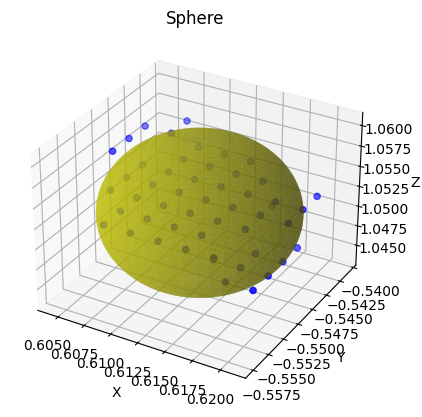

In [81]:
if shape == "Cylinder":
    draw_cylinder(points, params)
elif shape == "Plane" or shape == "Cuboid":    
    plot_planes_and_points(points, params)
elif shape == "Sphere":
    draw_sphere(points, params)